In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [3]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [31]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)

print(latitude)

[51.47 43.83 53.55 53.75 64.3  69.1  80.   68.3  63.75 48.53 82.52 51.27
 58.47 53.97 74.72 43.93 60.02 68.78 58.1  65.28 58.83 58.75 53.32 50.68
 50.22 53.9  35.05 45.45 57.75 40.35 58.68 40.17 42.75 35.23 61.17 55.03
 45.07 32.5  60.78 46.77 33.57 36.13 43.57 25.9  71.3  42.93 35.97 46.87
 55.2  41.66 32.9  27.77 37.77 39.86 29.37 32.17 39.78 29.37 42.7  41.62
 31.87 24.55 64.82 33.37 35.23 38.95 32.79 48.22 39.13 44.48 36.08 43.89
 38.95 39.43 40.15 48.57 19.72 32.32 30.5  18.43 10.58 41.13 30.12 34.73
 40.87 34.83 31.95 19.43 25.75 42.37 34.78 25.82 44.83 23.18 27.7  30.23
 32.85 24.57 33.02 37.73 41.32 35.4  40.87 64.5  47.7  66.87 35.22 40.67
 40.5  44.05 39.57 43.07 43.23 37.2   9.98 18.43 37.23 32.47 30.25 40.78
 44.92 57.16 27.7  47.46 30.4  39.07 32.12 47.95 44.07 36.05 37.93 32.37
 59.52 46.38 60.72]


In [79]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
print(x_g.shape) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
(28, 22)


[[61.78022886 60.14259826 58.50823532 56.87926838 55.25749913 53.64446821
  52.04150421 50.4497606  48.87024413 47.30383675 45.75131285 44.21335308
  42.69055536 41.18344403 39.69247736 38.21805387 36.76051778 35.32016365
  33.89724048 32.49195535 31.10447663 29.73493693]
 [62.27640234 60.60645817 58.94306363 57.28787676 55.64231271 54.00759229
  52.38477767 50.77479897 49.17847441 47.59652591 46.02959122 44.47823361
  42.94294969 41.42417588 39.92229379 38.43763479 36.97048402 35.52108382
  34.08963688 32.67630903 31.28123175 29.9045046 ]
 [62.66855588 60.97236874 59.28551849 57.60923972 55.94460529 54.29255669
  52.65392613 51.02945286 49.41979543 47.82554124 46.2472139  44.68527927
  43.14015027 41.61219107 40.10172049 38.60901516 37.13431217 35.67781156
  34.23967858 32.8200458  31.41901506 30.03665936]
 [62.95139368 61.23587881 59.53182402 57.84012732 56.16159283 54.496945
  52.84683897 51.21186807 49.59256963 47.98942944 46.4028854  44.83333047
  43.28111525 41.74655021 40.229907

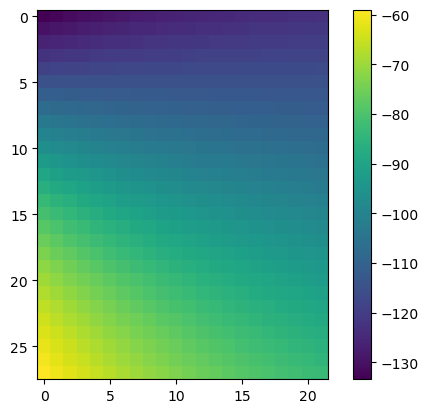

In [84]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
x_g_m = x_g/100
y_g_m = y_g/100
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = np.degrees(np.arctan(y_g/x_g))+lambda0 #x-cord, y-cord to longitude?

print(psi,lamda)
plt.imshow(lamda)
plt.colorbar()

In [85]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

#Getting the mean for each grid point based on radius around 
sigma = (1+np.sin(psi0)/1+np.sin(psi))

x_ob = rho*sigma*np.cos(psi)*np.sin(lamda)
y_ob = rho*sigma*np.cos(psi)*np.cos(lamda)

dx = x_ob 
dy = y_ob


[18.9  20.17 21.44 22.71 23.98 25.25 26.52 27.79 29.06 30.33 31.6  32.87
 34.14 35.41 36.68 37.95 39.22 40.49 41.76 43.03 44.3  45.57]


In [ ]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,ANALYSIS[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.show()


In [ ]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LON,LAT,N_OBS[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.show()

In [ ]:
### Store the analyses in text files ###



In [ ]:
### Store the number of observations available for each grid point in text files ###



In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    

'''